## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
from tensorflow.python import keras

# Disable GPU
#os.environ["CUDA_VISIBLE_DEVICES"] = ""

C:\Users\Hero3C\Anaconda3\envs\keras\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Hero3C\Anaconda3\envs\keras\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Hero3C\Anaconda3\envs\keras\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Hero3C\Anaconda3\envs\keras\lib\site-packages\tensorflow\pyth

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from tensorflow.python.keras.layers import BatchNormalization

"""
Code Here
建立你的神經網路
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model    
    

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.5, 0.6, 0.7]
redice_lr_patient = [5, 8, 10]

Using TensorFlow backend.


In [8]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, reduce_factor: 0.50, reduce_patient: 5
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
bat

50000/50000 [==============================] - 3s 58us/sample - loss: 1.3629 - accuracy: 0.5249 - val_loss: 1.5185 - val_accuracy: 0.4655
Epoch 9/25
50000/50000 [==============================] - 3s 59us/sample - loss: 1.3332 - accuracy: 0.5344 - val_loss: 1.5086 - val_accuracy: 0.4688
Epoch 10/25
50000/50000 [==============================] - 3s 56us/sample - loss: 1.3001 - accuracy: 0.5458 - val_loss: 1.4928 - val_accuracy: 0.4713
Epoch 11/25
50000/50000 [==============================] - 3s 59us/sample - loss: 1.2732 - accuracy: 0.5569 - val_loss: 1.4953 - val_accuracy: 0.4712
Epoch 12/25
50000/50000 [==============================] - 3s 60us/sample - loss: 1.2463 - accuracy: 0.5664 - val_loss: 1.4804 - val_accuracy: 0.4814
Epoch 13/25
50000/50000 [==============================] - 3s 59us/sample - loss: 1.2193 - accuracy: 0.5785 - val_loss: 1.4679 - val_accuracy: 0.4867
Epoch 14/25
50000/50000 [==============================] - 3s 59us/sample - loss: 1.1937 - accuracy: 0.5862 - val

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 5s 98us/sample - loss: 2.1972 - accuracy: 0.2737 - val_loss: 2.1271 - val_accuracy: 0.2389
Epoch 2/25
50000/50000 [==============================] - 3s 60us/sample - loss: 1.7338 - accuracy: 0.3962 - val_loss: 1.9707 - val_accuracy: 0.3040
Epoch 3/25
50000/50000 [==============================] - 3s 59us/sample - loss: 1.6078 - accuracy: 0.4372 - val_loss: 1.8290 - val_accuracy: 0.3639
Epoch 4/25
50000/50000 [==============================] - 3s 59us/sample - loss: 1.5366 - accuracy: 0.4630 - val_loss: 1.7161 - val_accuracy: 0.4049
Epoch 5/25
50000/50000 [==============================] - 3s 57us/sample - loss: 1.4811 - accuracy: 0.4843 - val_loss: 1.6332 - val_accuracy: 0.4291
Epoch 6/25
50000/50000 [==============================] - 3s 59us/sample - loss: 1.4370 - accuracy: 0.5003 - val_loss: 1.5916 - val_accuracy: 0.4422
Epoch 7/25
50000/50000 [==============================] 

50000/50000 [==============================] - 3s 60us/sample - loss: 1.0584 - accuracy: 0.6401 - val_loss: 1.4573 - val_accuracy: 0.4954
Epoch 21/25
50000/50000 [==============================] - 3s 57us/sample - loss: 1.0356 - accuracy: 0.6497 - val_loss: 1.4577 - val_accuracy: 0.4913
Epoch 22/25
50000/50000 [==============================] - 3s 59us/sample - loss: 1.0155 - accuracy: 0.6576 - val_loss: 1.4596 - val_accuracy: 0.4985
Epoch 23/25
50000/50000 [==============================] - 3s 60us/sample - loss: 0.9928 - accuracy: 0.6640 - val_loss: 1.4635 - val_accuracy: 0.4975
Epoch 24/25
50000/50000 [==============================] - 3s 60us/sample - loss: 0.9728 - accuracy: 0.6725 - val_loss: 1.4654 - val_accuracy: 0.4970
Epoch 25/25
50000/50000 [==============================] - 3s 60us/sample - loss: 0.9502 - accuracy: 0.6816 - val_loss: 1.4691 - val_accuracy: 0.4913
Numbers of exp: 5, reduce_factor: 0.60, reduce_patient: 10
Model: "model_5"
____________________________________

50000/50000 [==============================] - 3s 58us/sample - loss: 1.5540 - accuracy: 0.4584 - val_loss: 1.7130 - val_accuracy: 0.4093
Epoch 5/25
50000/50000 [==============================] - 3s 57us/sample - loss: 1.4992 - accuracy: 0.4752 - val_loss: 1.6363 - val_accuracy: 0.4280
Epoch 6/25
50000/50000 [==============================] - 3s 54us/sample - loss: 1.4553 - accuracy: 0.4913 - val_loss: 1.5946 - val_accuracy: 0.4404
Epoch 7/25
50000/50000 [==============================] - 3s 61us/sample - loss: 1.4153 - accuracy: 0.5066 - val_loss: 1.5528 - val_accuracy: 0.4540
Epoch 8/25
50000/50000 [==============================] - 3s 58us/sample - loss: 1.3817 - accuracy: 0.5178 - val_loss: 1.5243 - val_accuracy: 0.4639
Epoch 9/25
50000/50000 [==============================] - 3s 58us/sample - loss: 1.3498 - accuracy: 0.5306 - val_loss: 1.5123 - val_accuracy: 0.4709
Epoch 10/25
50000/50000 [==============================] - 3s 59us/sample - loss: 1.3191 - accuracy: 0.5426 - val_los

50000/50000 [==============================] - 3s 57us/sample - loss: 1.1214 - accuracy: 0.6187 - val_loss: 1.4663 - val_accuracy: 0.4831
Epoch 23/25
50000/50000 [==============================] - 3s 60us/sample - loss: 1.1038 - accuracy: 0.6245 - val_loss: 1.4669 - val_accuracy: 0.4873
Epoch 24/25
50000/50000 [==============================] - 3s 60us/sample - loss: 1.0882 - accuracy: 0.6325 - val_loss: 1.4604 - val_accuracy: 0.4882
Epoch 25/25
50000/50000 [==============================] - 3s 60us/sample - loss: 1.0694 - accuracy: 0.6397 - val_loss: 1.4636 - val_accuracy: 0.4906
Numbers of exp: 8, reduce_factor: 0.70, reduce_patient: 10
Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
______

50000/50000 [==============================] - 3s 63us/sample - loss: 1.1855 - accuracy: 0.5811 - val_loss: 1.6866 - val_accuracy: 0.4004
Epoch 7/25
50000/50000 [==============================] - 3s 61us/sample - loss: 1.1345 - accuracy: 0.5990 - val_loss: 1.9731 - val_accuracy: 0.3536
Epoch 8/25
50000/50000 [==============================] - 3s 62us/sample - loss: 1.0915 - accuracy: 0.6149 - val_loss: 2.0914 - val_accuracy: 0.3415
Epoch 9/25
50000/50000 [==============================] - 3s 61us/sample - loss: 1.0495 - accuracy: 0.6299 - val_loss: 1.8709 - val_accuracy: 0.3593
Epoch 10/25
50000/50000 [==============================] - 3s 63us/sample - loss: 0.9992 - accuracy: 0.6497 - val_loss: 1.6530 - val_accuracy: 0.4341
Epoch 11/25
50000/50000 [==============================] - 3s 62us/sample - loss: 0.9611 - accuracy: 0.6612 - val_loss: 1.8506 - val_accuracy: 0.3964
Epoch 12/25
50000/50000 [==============================] - 3s 60us/sample - loss: 0.9185 - accuracy: 0.6800 - val_l

50000/50000 [==============================] - 3s 63us/sample - loss: 0.5812 - accuracy: 0.8205 - val_loss: 1.5137 - val_accuracy: 0.5099
Epoch 23/25
50000/50000 [==============================] - 3s 65us/sample - loss: 0.5602 - accuracy: 0.8293 - val_loss: 1.5019 - val_accuracy: 0.5101
Epoch 24/25
50000/50000 [==============================] - 3s 62us/sample - loss: 0.5414 - accuracy: 0.8357 - val_loss: 1.5550 - val_accuracy: 0.5009
Epoch 25/25
50000/50000 [==============================] - 3s 64us/sample - loss: 0.5209 - accuracy: 0.8451 - val_loss: 1.5402 - val_accuracy: 0.5109
Numbers of exp: 11, reduce_factor: 0.50, reduce_patient: 10
Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
____

50000/50000 [==============================] - 3s 64us/sample - loss: 1.3026 - accuracy: 0.5472 - val_loss: 1.5404 - val_accuracy: 0.4605
Epoch 6/25
50000/50000 [==============================] - 3s 63us/sample - loss: 1.2515 - accuracy: 0.5665 - val_loss: 1.5375 - val_accuracy: 0.4522
Epoch 7/25
50000/50000 [==============================] - 3s 65us/sample - loss: 1.2090 - accuracy: 0.5841 - val_loss: 1.4931 - val_accuracy: 0.4773
Epoch 8/25
50000/50000 [==============================] - 3s 68us/sample - loss: 1.1710 - accuracy: 0.5974 - val_loss: 1.4705 - val_accuracy: 0.4817
Epoch 9/25
50000/50000 [==============================] - 3s 67us/sample - loss: 1.1360 - accuracy: 0.6108 - val_loss: 1.4666 - val_accuracy: 0.4797
Epoch 10/25
50000/50000 [==============================] - 3s 64us/sample - loss: 1.1020 - accuracy: 0.6248 - val_loss: 1.4632 - val_accuracy: 0.4833
Epoch 11/25
50000/50000 [==============================] - 3s 64us/sample - loss: 1.0698 - accuracy: 0.6366 - val_lo

49152/50000 [============================>.] - ETA: 0s - loss: 0.9065 - accuracy: 0.7050
Epoch 00023: ReduceLROnPlateau reducing learning rate to 2.2500001068692655e-05.
50000/50000 [==============================] - 3s 65us/sample - loss: 0.9068 - accuracy: 0.7053 - val_loss: 1.4227 - val_accuracy: 0.5038
Epoch 24/25
50000/50000 [==============================] - 3s 62us/sample - loss: 0.8830 - accuracy: 0.7159 - val_loss: 1.4283 - val_accuracy: 0.5057
Epoch 25/25
50000/50000 [==============================] - 3s 58us/sample - loss: 0.8700 - accuracy: 0.7219 - val_loss: 1.3959 - val_accuracy: 0.5140
Numbers of exp: 14, reduce_factor: 0.60, reduce_patient: 10
Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)          

50000/50000 [==============================] - 3s 60us/sample - loss: 1.3691 - accuracy: 0.5245 - val_loss: 1.5623 - val_accuracy: 0.4518
Epoch 7/25
50000/50000 [==============================] - 3s 64us/sample - loss: 1.3360 - accuracy: 0.5375 - val_loss: 1.5354 - val_accuracy: 0.4599
Epoch 8/25
50000/50000 [==============================] - 3s 65us/sample - loss: 1.3071 - accuracy: 0.5476 - val_loss: 1.5116 - val_accuracy: 0.4721
Epoch 9/25
50000/50000 [==============================] - 3s 62us/sample - loss: 1.2810 - accuracy: 0.5580 - val_loss: 1.4841 - val_accuracy: 0.4776
Epoch 10/25
50000/50000 [==============================] - 3s 64us/sample - loss: 1.2583 - accuracy: 0.5667 - val_loss: 1.4792 - val_accuracy: 0.4789
Epoch 11/25
50000/50000 [==============================] - 3s 62us/sample - loss: 1.2354 - accuracy: 0.5756 - val_loss: 1.4747 - val_accuracy: 0.4794
Epoch 12/25
50000/50000 [==============================] - 3s 64us/sample - loss: 1.2172 - accuracy: 0.5826 - val_l

50000/50000 [==============================] - 3s 63us/sample - loss: 1.0102 - accuracy: 0.6643 - val_loss: 1.4526 - val_accuracy: 0.4913
Numbers of exp: 17, reduce_factor: 0.70, reduce_patient: 10
Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_51 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_52 (Batc (None, 256)               1024      
__________________________________________________________

49152/50000 [============================>.] - ETA: 0s - loss: 1.1243 - accuracy: 0.6035
Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
50000/50000 [==============================] - 3s 63us/sample - loss: 1.1244 - accuracy: 0.6035 - val_loss: 1.9127 - val_accuracy: 0.3519
Epoch 10/25
50000/50000 [==============================] - 3s 62us/sample - loss: 1.0032 - accuracy: 0.6518 - val_loss: 1.5227 - val_accuracy: 0.4623
Epoch 11/25
50000/50000 [==============================] - 3s 60us/sample - loss: 0.9618 - accuracy: 0.6668 - val_loss: 1.5613 - val_accuracy: 0.4579
Epoch 12/25
50000/50000 [==============================] - 3s 61us/sample - loss: 0.9251 - accuracy: 0.6788 - val_loss: 1.5584 - val_accuracy: 0.4657
Epoch 13/25
50000/50000 [==============================] - 3s 61us/sample - loss: 0.8940 - accuracy: 0.6906 - val_loss: 1.5798 - val_accuracy: 0.4694
Epoch 14/25
50000/50000 [==============================] - 3s 61us/sample - loss: 0.8619 - ac

50000/50000 [==============================] - 3s 64us/sample - loss: 0.6268 - accuracy: 0.8045 - val_loss: 1.6936 - val_accuracy: 0.4630
Numbers of exp: 20, reduce_factor: 0.50, reduce_patient: 10
Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_60 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_61 (Batc (None, 256)               1024      
__________________________________________________________

50000/50000 [==============================] - 3s 62us/sample - loss: 1.3051 - accuracy: 0.5455 - val_loss: 1.5484 - val_accuracy: 0.4526
Epoch 9/25
50000/50000 [==============================] - 3s 62us/sample - loss: 1.2694 - accuracy: 0.5607 - val_loss: 1.5338 - val_accuracy: 0.4554
Epoch 10/25
50000/50000 [==============================] - 3s 61us/sample - loss: 1.2358 - accuracy: 0.5724 - val_loss: 1.4796 - val_accuracy: 0.4768
Epoch 11/25
50000/50000 [==============================] - 3s 60us/sample - loss: 1.2031 - accuracy: 0.5849 - val_loss: 1.4633 - val_accuracy: 0.4829
Epoch 12/25
50000/50000 [==============================] - 3s 57us/sample - loss: 1.1735 - accuracy: 0.5973 - val_loss: 1.5329 - val_accuracy: 0.4622
Epoch 13/25
50000/50000 [==============================] - 3s 62us/sample - loss: 1.1441 - accuracy: 0.6090 - val_loss: 1.5499 - val_accuracy: 0.4588
Epoch 14/25
50000/50000 [==============================] - 3s 64us/sample - loss: 1.1174 - accuracy: 0.6211 - val

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 5s 102us/sample - loss: 2.1297 - accuracy: 0.2877 - val_loss: 2.1477 - val_accuracy: 0.2422
Epoch 2/25
50000/50000 [==============================] - 3s 64us/sample - loss: 1.8052 - accuracy: 0.3778 - val_loss: 2.0032 - val_accuracy: 0.3122
Epoch 3/25
50000/50000 [==============================] - 3s 63us/sample - loss: 1.6780 - accuracy: 0.4175 - val_loss: 1.8597 - val_accuracy: 0.3608
Epoch 4/25
50000/50000 [==============================] - 3s 63us/sample - loss: 1.5950 - accuracy: 0.4449 - val_loss: 1.7542 - val_accuracy: 0.3893
Epoch 5/25
50000/50000 [==============================] - 3s 62us/sample - loss: 1.5329 - accuracy: 0.4673 - val_loss: 1.6887 - val_accuracy: 0.4105
Epoch 6/25
50000/50000 [==============================] - 3s 60us/sample - loss: 1.4820 - accuracy: 0.4849 - val_loss: 1.6375 - val_accuracy: 0.4296
Epoch 7/25
50000/50000 [==============================]

50000/50000 [==============================] - 3s 65us/sample - loss: 1.1092 - accuracy: 0.6262 - val_loss: 1.4937 - val_accuracy: 0.4823
Epoch 21/25
50000/50000 [==============================] - 3s 63us/sample - loss: 1.0916 - accuracy: 0.6330 - val_loss: 1.5328 - val_accuracy: 0.4761
Epoch 22/25
50000/50000 [==============================] - 3s 60us/sample - loss: 1.0735 - accuracy: 0.6391 - val_loss: 1.4774 - val_accuracy: 0.4919
Epoch 23/25
50000/50000 [==============================] - 3s 64us/sample - loss: 1.0568 - accuracy: 0.6460 - val_loss: 1.4967 - val_accuracy: 0.4824
Epoch 24/25
50000/50000 [==============================] - 3s 63us/sample - loss: 1.0390 - accuracy: 0.6526 - val_loss: 1.4965 - val_accuracy: 0.4840
Epoch 25/25
50000/50000 [==============================] - 3s 65us/sample - loss: 1.0237 - accuracy: 0.6593 - val_loss: 1.5273 - val_accuracy: 0.4746
Numbers of exp: 25, reduce_factor: 0.70, reduce_patient: 8
Model: "model_25"
___________________________________

50000/50000 [==============================] - 3s 63us/sample - loss: 1.5984 - accuracy: 0.4426 - val_loss: 1.7688 - val_accuracy: 0.3928
Epoch 5/25
50000/50000 [==============================] - 3s 62us/sample - loss: 1.5339 - accuracy: 0.4655 - val_loss: 1.6866 - val_accuracy: 0.4076
Epoch 6/25
50000/50000 [==============================] - 3s 62us/sample - loss: 1.4830 - accuracy: 0.4849 - val_loss: 1.6335 - val_accuracy: 0.4223
Epoch 7/25
50000/50000 [==============================] - 3s 62us/sample - loss: 1.4372 - accuracy: 0.5007 - val_loss: 1.5860 - val_accuracy: 0.4408
Epoch 8/25
50000/50000 [==============================] - 3s 60us/sample - loss: 1.4001 - accuracy: 0.5126 - val_loss: 1.5622 - val_accuracy: 0.4479
Epoch 9/25
50000/50000 [==============================] - 3s 64us/sample - loss: 1.3656 - accuracy: 0.5255 - val_loss: 1.5667 - val_accuracy: 0.4401
Epoch 10/25
50000/50000 [==============================] - 3s 62us/sample - loss: 1.3341 - accuracy: 0.5378 - val_los

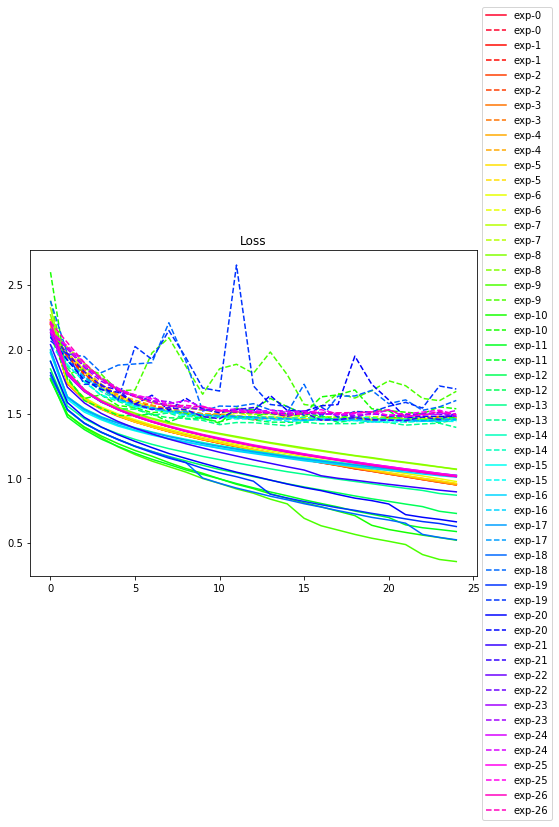

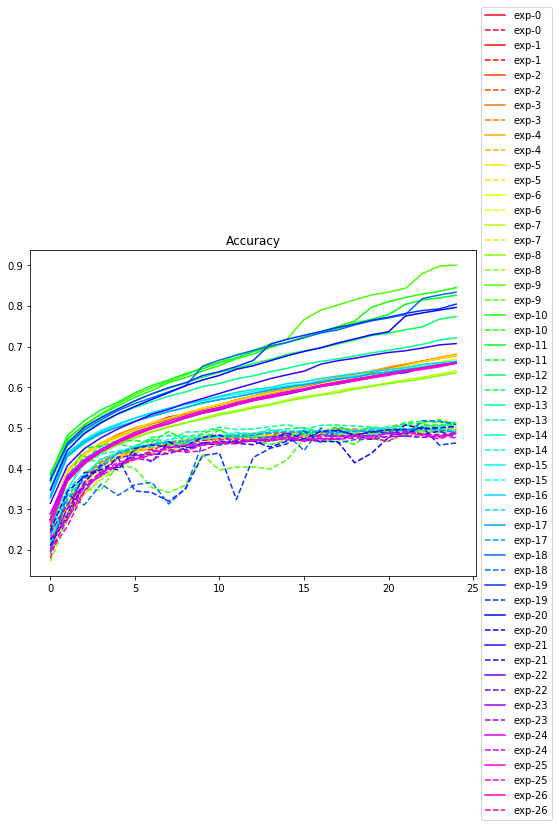

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()